### Part of Speech(POS) Tagging using Hidden Markov Model(HMM) and Viterbi Heuristics

 Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Developing algorithm for Viterbi Heuristic
4. Checking accuracy on the test data set

In [2]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [5]:
# Read the Treebank tagged sentences
#wsj is a list of list of tuples Tuple consists of word and corresponding POS tag
wsj = list(nltk.corpus.treebank.tagged_sents())

In [6]:
wsj[:10]

[[('Pierre', 'NNP'),
  ('Vinken', 'NNP'),
  (',', ','),
  ('61', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  (',', ','),
  ('will', 'MD'),
  ('join', 'VB'),
  ('the', 'DT'),
  ('board', 'NN'),
  ('as', 'IN'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('Nov.', 'NNP'),
  ('29', 'CD'),
  ('.', '.')],
 [('Mr.', 'NNP'),
  ('Vinken', 'NNP'),
  ('is', 'VBZ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Elsevier', 'NNP'),
  ('N.V.', 'NNP'),
  (',', ','),
  ('the', 'DT'),
  ('Dutch', 'NNP'),
  ('publishing', 'VBG'),
  ('group', 'NN'),
  ('.', '.')],
 [('Rudolph', 'NNP'),
  ('Agnew', 'NNP'),
  (',', ','),
  ('55', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  ('and', 'CC'),
  ('former', 'JJ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Consolidated', 'NNP'),
  ('Gold', 'NNP'),
  ('Fields', 'NNP'),
  ('PLC', 'NNP'),
  (',', ','),
  ('was', 'VBD'),
  ('named', 'VBN'),
  ('*-1', '-NONE-'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('of', 'IN'),
  ('this'

In [8]:
# Split into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:10])

2739
1175
[[('It', 'PRP'), ('was', 'VBD'), ('outrageous', 'JJ'), ('.', '.')], [('Jim', 'NNP'), ('Enzor', 'NNP'), ('of', 'IN'), ('Atlanta', 'NNP'), ('defends', 'VBZ'), ('program', 'NN'), ('trading', 'NN'), ('because', 'IN'), ('he', 'PRP'), ('believes', 'VBZ'), ('that', 'IN'), ('it', 'PRP'), ('can', 'MD'), ('bring', 'VB'), ('the', 'DT'), ('market', 'NN'), ('back', 'RB'), ('up', 'IN'), ('after', 'IN'), ('a', 'DT'), ('plunge', 'NN'), ('.', '.')], [('And', 'CC'), (',', ','), ('says', 'VBZ'), ('0', '-NONE-'), ('*T*-1', '-NONE-'), ('Mr.', 'NNP'), ('Dinkins', 'NNP'), (',', ','), ('he', 'PRP'), ('did', 'VBD'), ("n't", 'RB'), ('know', 'VB'), ('0', '-NONE-'), ('the', 'DT'), ('man', 'NN'), ('0', '-NONE-'), ('his', 'PRP$'), ('campaign', 'NN'), ('paid', 'VBD'), ('*T*-2', '-NONE-'), ('for', 'IN'), ('a', 'DT'), ('get-out-the-vote', 'JJ'), ('effort', 'NN'), ('had', 'VBD'), ('been', 'VBN'), ('convicted', 'VBN'), ('*-3', '-NONE-'), ('of', 'IN'), ('kidnapping', 'NN'), ('.', '.')], [('Output', 'NN'), ('wil

In [9]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70193

In [10]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['It',
 'was',
 'outrageous',
 '.',
 'Jim',
 'Enzor',
 'of',
 'Atlanta',
 'defends',
 'program']

In [11]:
# vocabulary
V = set(tokens)
print(len(V))

10237


In [12]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

46

In [13]:
print(T)

{'VBG', 'NNS', 'CD', '#', 'DT', 'NN', 'IN', 'PDT', '-LRB-', 'WP$', 'WRB', ':', '``', 'LS', 'NNP', 'FW', 'POS', ',', 'RP', 'WP', 'VB', 'NNPS', 'VBN', 'JJS', 'VBD', '-NONE-', 'SYM', 'UH', 'RB', 'PRP$', '.', 'PRP', 'JJR', 'RBS', 'WDT', 'VBP', '$', 'CC', "''", 'JJ', 'RBR', 'MD', 'VBZ', 'EX', '-RRB-', 'TO'}


#### Calculate Emission Probability and Tranisition Proabailities

#### Emission Probabilities

In [14]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [15]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [16]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(20, 4089)
(0, 1757)
(0, 9165) 


 will
(195, 654)
(1, 9165)
(0, 1757)

 book
(6, 9165)
(1, 1757)


#### Transition Probabilities

In [18]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(135, 4089)
(1824, 4089)
(2692, 5717)
(63, 1757)
(1044, 6596)
(1, 1197)
(7, 6596)


In [20]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))

(565, 2706)
(10, 2706)
(121, 2706)
(489, 2706)


In [21]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [22]:
tags_matrix

array([[0.        , 0.09566969, 0.01812689, ..., 0.        , 0.00100705,
        0.04330312],
       [0.01241939, 0.01170289, 0.00095534, ..., 0.        , 0.00167184,
        0.01862909],
       [0.00082102, 0.14408867, 0.18472907, ..., 0.        , 0.00123153,
        0.02504105],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01176471, 0.        , ..., 0.        , 0.        ,
        0.01176471],
       [0.00067613, 0.0270453 , 0.07234618, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [23]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [24]:
tags_df

,VBG,NNS,CD,#,DT,NN,IN,PDT,-LRB-,WP$,...,$,CC,'',JJ,RBR,MD,VBZ,EX,-RRB-,TO
VBG,0.000000,0.095670,0.018127,0.000000,0.188318,0.154079,0.124874,0.001007,0.000000,0.000000,...,0.008056,0.010070,0.000000,0.072508,0.003021,0.000000,0.001007,0.000000,0.001007,0.043303
NNS,0.012419,0.011703,0.000955,0.000000,0.012897,0.022928,0.243611,0.000000,0.002866,0.000955,...,0.000717,0.058276,0.004299,0.017674,0.001433,0.029377,0.008359,0.000000,0.001672,0.018629
CD,0.000821,0.144089,0.184729,0.000000,0.002053,0.186371,0.036125,0.000000,0.001642,0.000411,...,0.000000,0.015189,0.000411,0.036946,0.000821,0.002463,0.002463,0.000000,0.001232,0.025041
#,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.009795,0.074340,0.022564,0.000000,0.001574,0.470876,0.009446,0.000000,0.000525,0.000000,...,0.008221,0.000350,0.000175,0.205178,0.001224,0.001224,0.004898,0.000000,0.000175,0.000350
NN,0.007529,0.082051,0.004364,0.000000,0.005128,0.127878,0.242990,0.000000,0.001528,0.000000,...,0.000327,0.036661,0.006328,0.008292,0.000764,0.014730,0.043535,0.000000,0.001637,0.020295
IN,0.003913,0.063913,0.063768,0.001159,0.319130,0.105942,0.017681,0.001014,0.000000,0.000145,...,0.026087,0.000870,0.000145,0.095797,0.000870,0.000145,0.000290,0.001014,0.000000,0.001594
PDT,0.000000,0.000000,0.000000,0.000000,0.894737,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-LRB-,0.011765,0.035294,0.047059,0.000000,0.094118,0.070588,0.094118,0.000000,0.000000,0.000000,...,0.152941,0.000000,0.000000,0.023529,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000
WP$,0.000000,0.444444,0.000000,0.000000,0.000000,0.555556,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
tags_df.loc['.', :]

VBG       0.003695
NNS       0.042129
CD        0.008500
#         0.000000
DT        0.208795
NN        0.044715
IN        0.116408
PDT       0.000739
-LRB-     0.004435
WP$       0.000000
WRB       0.005913
:         0.003326
``        0.079453
LS        0.001848
NNP       0.180710
FW        0.000000
POS       0.000000
,         0.000000
RP        0.000000
WP        0.004065
VB        0.000739
NNPS      0.003326
VBN       0.001478
JJS       0.001848
VBD       0.000739
-NONE-    0.022173
SYM       0.000000
UH        0.000000
RB        0.040281
PRP$      0.008130
.         0.000000
PRP       0.057280
JJR       0.002956
RBS       0.000739
WDT       0.000739
VBP       0.000000
$         0.001109
CC        0.045824
''        0.061715
JJ        0.032520
RBR       0.000739
MD        0.000000
VBZ       0.002217
EX        0.004065
-RRB-     0.004804
TO        0.001478
Name: ., dtype: float32

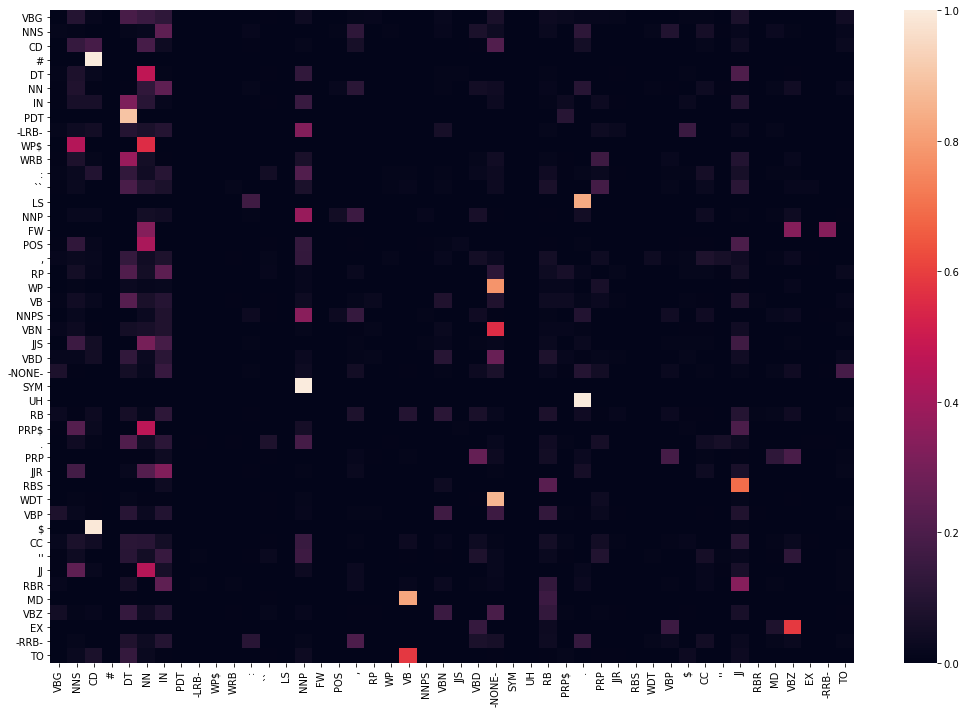

In [28]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

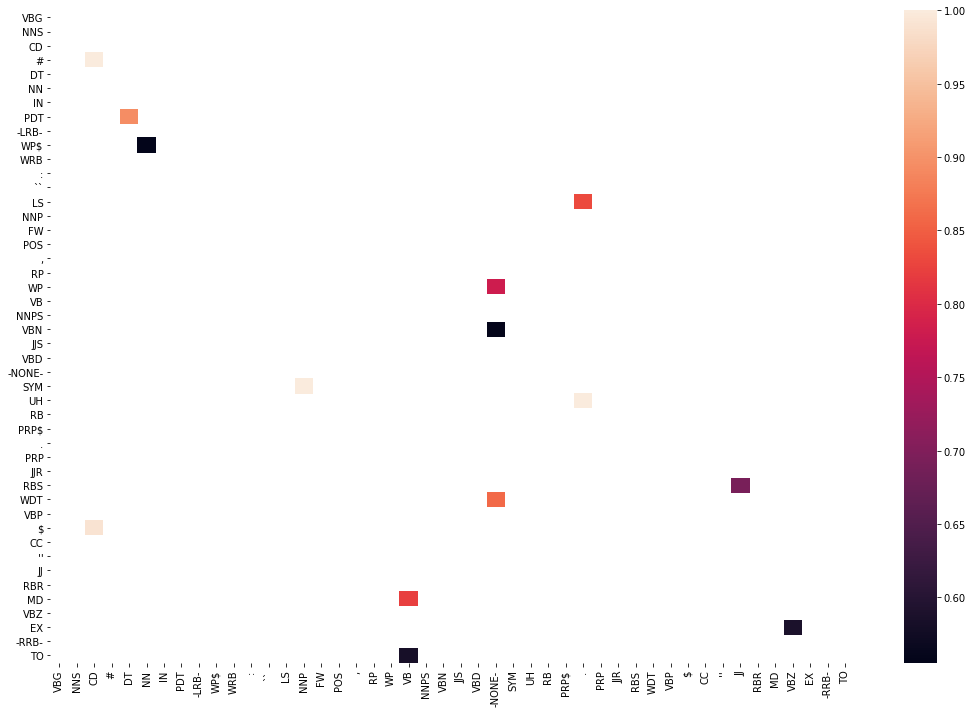

In [29]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

#### Viterbi Alogrithm
Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [27]:
len(train_tagged_words)

70193

In [30]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Evaluate on Test set

In [34]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('In', 'IN'),
  ('less', 'JJR'),
  ('parched', 'VBN'),
  ('areas', 'NNS'),
  (',', ','),
  ('meanwhile', 'RB'),
  (',', ','),
  ('farmers', 'NNS'),
  ('who', 'WP'),
  ('*T*-43', '-NONE-'),
  ('had', 'VBD'),
  ('little', 'JJ'),
  ('or', 'CC'),
  ('no', 'DT'),
  ('loss', 'NN'),
  ('of', 'IN'),
  ('production', 'NN'),
  ('profited', 'VBD'),
  ('greatly', 'RB'),
  ('from', 'IN'),
  ('the', 'DT'),
  ('higher', 'JJR'),
  ('prices', 'NNS'),
  ('.', '.')],
 [('The', 'DT'),
  ('filing', 'NN'),
  ('on', 'IN'),
  ('the', 'DT'),
  ('details', 'NNS'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('spinoff', 'NN'),
  ('caused', 'VBD'),
  ('Cray', 'NNP'),
  ('Research', 'NNP'),
  ('stock', 'NN'),
  ('to', 'TO'),
  ('jump', 'VB'),
  ('$', '$'),
  ('2.875', 'CD'),
  ('*U*', '-NONE-'),
  ('yesterday', 'NN'),
  ('*-1', '-NONE-'),
  ('to', 'TO'),
  ('close', 'VB'),
  ('at', 'IN'),
  ('$', '$'),
  ('38', 'CD'),
  ('*U*', '-NONE-'),
  ('in', 'IN'),
  ('New', 'NNP'),
  ('York', 'NNP'),
  ('Stock', 'NNP'),
  ('Exchan

In [35]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [36]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  78.7389829158783
[('In', 'IN'), ('less', 'JJR'), ('parched', 'VBG'), ('areas', 'NNS'), (',', ','), ('meanwhile', 'RB'), (',', ','), ('farmers', 'NNS'), ('who', 'WP'), ('*T*-43', '-NONE-'), ('had', 'VBD'), ('little', 'RB'), ('or', 'CC'), ('no', 'DT'), ('loss', 'NN'), ('of', 'IN'), ('production', 'NN'), ('profited', 'VBG'), ('greatly', 'RB'), ('from', 'IN'), ('the', 'DT'), ('higher', 'JJR'), ('prices', 'NNS'), ('.', '.'), ('The', 'DT'), ('filing', 'NN'), ('on', 'IN'), ('the', 'DT'), ('details', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('spinoff', 'NN'), ('caused', 'VBD'), ('Cray', 'NNP'), ('Research', 'NNP'), ('stock', 'NN'), ('to', 'TO'), ('jump', 'VB'), ('$', '$'), ('2.875', 'VBG'), ('*U*', '-NONE-'), ('yesterday', 'NN'), ('*-1', '-NONE-'), ('to', 'TO'), ('close', 'VB'), ('at', 'IN'), ('$', '$'), ('38', 'CD'), ('*U*', '-NONE-'), ('in', 'IN'), ('New', 'NNP'), ('York', 'NNP'), ('Stock', 'NNP'), ('Exchange', 'NNP'), ('composite', 'JJ'), ('trading', 'NN'), ('.', '.'), (

In [37]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [38]:
accuracy = len(check)/len(tagged_seq)

In [39]:
accuracy

0.9083969465648855

In [40]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [41]:
incorrect_tagged_cases

[[('less', 'JJR'), (('parched', 'VBG'), ('parched', 'VBN'))],
 [('had', 'VBD'), (('little', 'RB'), ('little', 'JJ'))],
 [('production', 'NN'), (('profited', 'VBG'), ('profited', 'VBD'))],
 [('$', '$'), (('2.875', 'VBG'), ('2.875', 'CD'))],
 [('the', 'DT'), (('Spanish', 'VBG'), ('Spanish', 'NNP'))],
 [('Spanish', 'NNP'),
  (('Renaissance-style', 'VBG'), ('Renaissance-style', 'JJ'))],
 [('East', 'NNP'), (('German', 'JJ'), ('German', 'NNP'))],
 [('leader', 'NN'), (('Krenz', 'VBG'), ('Krenz', 'NNP'))],
 [('Krenz', 'NNP'), (('called', 'VBN'), ('called', 'VBD'))],
 [('democratic', 'JJ'), (('freedoms', 'VBG'), ('freedoms', 'NNS'))],
 [('for', 'IN'), (('socialism', 'VBG'), ('socialism', 'NN'))],
 [('weeks', 'NNS'), (('earlier', 'JJR'), ('earlier', 'RBR'))]]

In [67]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'

words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [69]:
print(tagged_seq)
print(difference)

[('Twitter', 'VBG'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('networking', 'VBG'), ('social', 'JJ'), ('site', 'VBG'), ('.', '.'), ('Man', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), ('animal', 'VBG'), ('.', '.'), ('Data', 'NNP'), ('science', 'VBG'), ('is', 'VBZ'), ('an', 'DT'), ('emerging', 'VBG'), ('field', 'NN'), ('.', '.'), ('Data', 'NNP'), ('science', 'VBG'), ('jobs', 'NNS'), ('are', 'VBP'), ('high', 'JJ'), ('in', 'IN'), ('demand', 'NN'), ('.', '.')]
18.73650550842285
